# DEEP LEARNING MODELS IMAGE

##### Comme les modèles baseline sur les images ont donné des résultats assez mitigés (environ 50% de classifications correctes), on va essayer des modèles de CNN / DeepLearning. 
##### Les modèles que l'on va tester sont les suivants: 
- ViT : Vision Transformer (architecture transformer, mécanisme d'attention, nécessite bcp de données)
- EfficientNet (CNN, perfs élevées avec peu de paramètres, compound scaling, peu modulaire)
- ResNet (mécanisme de skip connections, réseaux profonds)
- VGG (architecture simple, lourd en calcul)
- Inception (conv de différentes tailles, extraction multi-échelle)

In [1]:
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from collections import Counter
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import RandomRotation, RandomResizedCrop, RandomHorizontalFlip, ToTensor, Normalize
from torchvision.models import resnet50, vgg16, efficientnet_b5, vit_l_16
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import nn

## Importation des fichiers / dossiers

In [2]:
# infos sur les images
csv_file = "../data/csv_files/img-data.csv"
df = pd.read_csv(csv_file)
display(df.head())

# Vérification classes et nb images
print(df['prdtypecode'].value_counts())

# path dossier images
img_dir = "../data/processed/balanced_image_train"

,designation,description,productid,imageid,image name,image size in bits,prdtypecode,désignation textuelle,catégorie niv 1
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,image_1263597046_product_3804725264.jpg,14010,10,Livres anciens / occasion,Littérature
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,image_1008141237_product_436067568.jpg,14854,2280,"journaux, revues, magazines anciens",Littérature
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,image_938777978_product_201115110.jpg,6898,50,Accessoires & produits dérivés gaming,Jeux Vidéos
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,image_457047496_product_50418756.jpg,14404,1280,Jeux & jouets pour enfants,Jeux de société & Jouets
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,image_1077757786_product_278535884.jpg,20435,2705,Livres neufs,Littérature


prdtypecode
2583    10209
1560     5073
1300     5045
2060     4993
2522     4989
1280     4870
2403     4774
2280     4760
1920     4303
1160     3953
1320     3241
10       3116
2705     2761
1140     2671
2582     2589
40       2508
2585     2496
1302     2491
1281     2070
50       1681
2462     1421
2905      872
60        832
2220      824
1301      807
1940      803
1180      764
Name: count, dtype: int64


## Preprocessing des images 
##### Ci-dessous une fonction qui permet d'effectuer un preprocessing différent pour chaque type de réseau

In [3]:
def get_transformations(model_name):
    '''
    - desc : applique les transformations nécessaires aux images en fonction du modèle
    - params:
      -> model_name : nom du modèle
    - returns: images transformées (train + val)
    '''

    # Détermine la taille de l'image en fonction du modèle
    if model_name in ['resnet', 'vgg', 'vit']:
        input_size = 224
    elif model_name == 'efficientnet_b0':
        input_size = 240
    elif model_name == 'efficientnet_b5':
        input_size = 456
    else:
        raise ValueError(f"Modèle non supporté : {model_name}")

    # train : redimensionnement, recadrage, shearing, rotations, flips, normalisation et conversion en tenseur
    transform_train = transforms.Compose([
        transforms.Resize(input_size),
        transforms.RandomResizedCrop(input_size),
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ])

    # val : redimensionnement, recadrage, normalisation et conversion en tenseur
    transform_val = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ])

    return transform_train, transform_val

In [4]:
def prepare_data(img_dir, model_name):
    '''
    - desc : prépare les images avant de les fournir au modèle : transformations, train/test split, etc.
    - params:
      -> img_dir : path du dossier images
      -> model_name : nom du modèle$
    - returns: datasets train / test prêts à être utilisés
    '''
    # transformations train / test
    transform_train, transform_val = get_transformations(model_name)

    # formation du dataset depuis "img_dir" avec application des transformations
    dataset = ImageFolder(img_dir, transform = transform_train)

    # Récupération du nombre d'images par classe
    class_count = Counter(dataset.targets)
    min_class_count = min(class_count.values())
    print("Nombre d'images par classe:\n", class_count)
    print("Classe ayant le plus petit nombre d'images:\n", min_class_count)

    # Récupération de 1000 images max par catégorie 
    balanced_indices = []
    max_imgs = 1000
    for class_idx, count in class_count.items():
        class_indices = [i for i, x in enumerate(dataset.targets) if x == class_idx]
        balanced_indices.extend(class_indices[:max_imgs])
    print(balanced_indices)

    # Equilibrage du dataset
    balanced_sampler = SubsetRandomSampler(balanced_indices)

    # train / test split
    train_size = int(0.8 * len(balanced_indices))
    print("train size : ", train_size)
    val_size = len(balanced_indices) - train_size
    print("val size = ", val_size)
    train_indices, val_indices = train_test_split(balanced_indices, train_size = train_size, random_state = 42)

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    # train / test dataloader, chargement des données en batch
    batch_size = 32
    train_loader = DataLoader(dataset, batch_size = batch_size, sampler = train_sampler)
    val_loader = DataLoader(dataset, batch_size = batch_size, sampler = val_sampler)

    return train_loader, val_loader

##### Test du preprocessing

In [5]:
# Nom du modèle
model_name = "vit"
# Dataset
train_loader, val_loader = prepare_data(img_dir, model_name)


Nombre d'images par classe:
 Counter({0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000, 10: 1000, 11: 1000, 12: 1000, 13: 1000, 14: 1000, 15: 1000, 16: 1000, 17: 1000, 18: 1000, 19: 1000, 20: 1000, 21: 1000, 22: 1000, 23: 1000, 24: 1000, 25: 1000, 26: 1000})
Classe ayant le plus petit nombre d'images:
 1000
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 

##### Vérification du preprocessing

Nombre d'échantillons dans train_loader: 27000
Nombre d'échantillons dans train_loader.sampler : 21600
Nombre d'échantillons dans val_loader: 27000
Nombre d'échantillons dans val_loader.sampler : 5400
Exemple d'images de train_loader:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


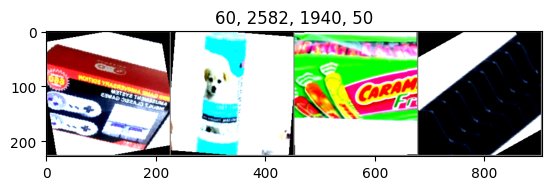

Exemple d'images de val_loader:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


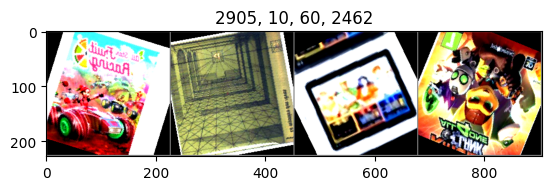

Dimensions des images dans train_loader: torch.Size([32, 3, 224, 224])
Dimensions des labels dans train_loader: torch.Size([32])
Dimensions des images dans val_loader: torch.Size([32, 3, 224, 224])
Dimensions des labels dans val_loader: torch.Size([32])


In [6]:
def imshow(img, title = None):
    '''
    - desc : affiche l'image img après avoir l'avoir dénormalisée et convertie de tenseur à tableau numpy
    - params:
      -> img : tenseur image
      -> title : titre de l'image (optionnel)
    '''
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

def display_sample_images(dataloader, num_images = 4):
    '''
    - desc: affiche des images du dataloader
    - params:
      -> dataloader
      -> num_images : nb d'images max à afficher pour le dataloader
    '''
    # mapping index -> nom de classe
    idx_to_class = {v: k for k, v in dataloader.dataset.class_to_idx.items()}
    
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    # nom de la classe à partir du labal
    class_names = [idx_to_class[label.item()] for label in labels[:num_images]]
    # grille
    img_grid = torchvision.utils.make_grid(images[:num_images])
    # Affichage
    imshow(img_grid, title=', '.join(class_names))

def check_dataloaders(train_loader, val_loader):
    '''
    - desc: Effectue une vérification des loaders : nb d'images, affichage, taille des tenseurs
    - params:
      -> train_loader : dataloader de l'ensemble d'entraînement
      -> val_loader : dataloader de l'ensemble de test
    '''
    print("Nombre d'échantillons dans train_loader:", len(train_loader.dataset))
    print("Nombre d'échantillons dans train_loader.sampler :", len(train_loader.sampler))
    print("Nombre d'échantillons dans val_loader:", len(val_loader.dataset))
    print("Nombre d'échantillons dans val_loader.sampler :", len(val_loader.sampler))
    
    # Affichage de quelques images
    print("Exemple d'images de train_loader:")
    display_sample_images(train_loader)

    print("Exemple d'images de val_loader:")
    display_sample_images(val_loader)

    # Afficher les dimensions des images
    # train
    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    print("Dimensions des images dans train_loader:", images.shape)
    print("Dimensions des labels dans train_loader:", labels.shape)
    # test
    data_iter = iter(val_loader)
    images, labels = next(data_iter)
    print("Dimensions des images dans val_loader:", images.shape)
    print("Dimensions des labels dans val_loader:", labels.shape)

# Vérification
check_dataloaders(train_loader, val_loader)


## Modélisation

### Configuraton des modèles

##### La fonction ci-dessous permet de charger et de configurer les couches du modèle passé en paramètre

In [7]:
def get_model(model_name, num_classes = 27):
    '''
    - desc: Charge le modèle pré-entraîné et définit la couche de sortie
    - params:
      -> model_name: nom du modèle
      -> num_classes: nombre de classes pour la couche de sortie (par défaut 27)
    - returns: Modèle pré-entraîné
    '''
    if model_name == 'resnet':
        # gel des couches pré-entraînées
        model = resnet50(pretrained = True)
        for param in model.parameters():
            param.requires_grad = False
        # ajout couche de classification (entraînable)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        for param in model.fc.parameters():
            param.requires_grad = True

    elif model_name == 'vgg':
        model = vgg16(pretrained = True)
        # gel des couches pré-entraînées
        for param in model.parameters():
            param.requires_grad = False
        # ajout couche de classification (entraînable)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        for param in model.classifier[6].parameters():
            param.requires_grad = True

    elif model_name == 'efficientnet':
        model = efficientnet_b5(pretrained = True)
        # gel des couches pré-entraînées
        for param in model.parameters():
            param.requires_grad = False
        # ajout couche de classification (entraînable)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        for param in model.classifier[1].parameters():
            param.requires_grad = True

    elif model_name == 'vit':
        model = vit_l_16(pretrained = True)
        # gel des couches pré-entraînées
        for param in model.parameters():
            param.requires_grad = False
        # ajout couche de classification (entraînable)
        model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
        for param in model.heads.head.parameters():
            param.requires_grad = True
    
    else:
        raise ValueError(f"Modèle non supporté : {model_name}")

    return model


### Sauvegarde du Modèle et des poids 

##### Le code ci-dessous permet de sauvegarder l'état du modèle pour poursuivre un entraînement ou effectuer des prédictions

In [8]:
def save_checkpoint(model, optimizer, epoch, total_epochs, model_name, path, val_loss):
    '''
    - desc: Sauvegarde les poids et l'état du modèle.
    - params:
      -> model: le modèle à sauvegarder
      -> optimizer: l'optimiseur
      -> epoch: epoch actuelle
      -> total_epochs: nombre total d'epoch
      -> model_name: nom du modèle
      -> path: chemin de sauvegarde
      -> val_loss: perte de validation
    '''
    # Date actuelle
    date_str = datetime.datetime.now().strftime("%Y-%m-%d")
    
    # Path de sauvegarde
    checkpoint_path = os.path.join(path, f"{model_name}_{date_str}_epoch{epoch+1}of{total_epochs}.pth")

    # Sauvegarde
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_loss': val_loss,
    }, checkpoint_path)
    
    print(f"Modèle sauvegardé à {checkpoint_path}")


### Chargement d'un modèle

##### La fonction ci-dessous permet de charger un modèle sauvegardé

In [9]:
def load_model(checkpoint_path, model, device):
    '''
    - desc: charge le modèle et l'optimiseur à partir d'un checkpoint
    - params:
      -> checkpoint_path (str): chemin vers le fichier .pth contenant les poids et l'état de l'optimiseur
      -> model: modèle à mettre à jour
      -> device (str): cpu ou gpu
    - returns:
      -> model: modèle avec les poids chargés
      -> start_epoch (int): dernière époque sauvegardée
      -> learning_rate (float): taux d'apprentissage sauvegardé
    '''
    if not os.path.isfile(checkpoint_path):
        raise FileNotFoundError(f"Le fichier {checkpoint_path} n'existe pas")

    checkpoint = torch.load(checkpoint_path, map_location = device)

    print("---------------------")
    print("Chargement d'un checkpoint")
    print("Clés du checkpoint :", checkpoint.keys())
    # epoch
    start_epoch = checkpoint['epoch']
    print(f"Continuer l'entraînement à partir de l'époque {start_epoch + 1}")
    # val_loss
    print("val_loss :", checkpoint['val_loss'])
    # model
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Modèle chargé avec succès depuis", checkpoint_path)
    # optimizer
    optimizer = optim.Adam(model.parameters())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print("Optimiseur chargé avec succès")
    # learning_rate
    for param_group in optimizer.param_groups:
      learning_rate = param_group['lr']
    print("learning_rate : ", learning_rate)
    print("---------------------")
    
    return model, start_epoch, learning_rate

### Entraînement des modèles

##### Définition des early stopping 
(si les performances ne s'améliorent pas après un certain nombre d'epoch)

In [10]:
class EarlyStopping:
    def __init__(self, model_name, path, patience=5, delta=0):
        self.model_name = model_name
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.best_loss = float('inf')
        self.path = path

    def __call__(self, val_loss, model, optimizer, epoch, total_epochs):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                print(f"Early stopping déclenché. Sauvegarde du meilleur modèle...")
                self.save_best_model(model, optimizer, epoch, total_epochs, val_loss)
        else:
            self.best_score = score
            self.counter = 0

    def save_best_model(self, model, optimizer, epoch, total_epochs, val_loss):
        '''
        - desc: Sauvegarde le meilleur modèle uniquement lorsque l'early stopping est déclenché.
        '''
        best_model_path = os.path.join(self.path, f"{self.model_name}_best.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, best_model_path)
        print(f"Meilleur modèle sauvegardé à : {best_model_path}")



##### Le code ci-dessous permet d'entraîner le modèle selon certains paramètres et retourne la précision et la perte

In [11]:
def train_model(model, model_name, device, path, train_loader, val_loader, learning_rate = 0.001, num_epochs = 10):
    '''
    - desc: entraîne le modèle avec les paramètres associés
    - params:
      -> model: modèle (vgg, resnet, etc.)
      -> model_name (str): nom du modèle
      -> device (str): cpu or gpu
      -> path (str): chemin de sauvegarde pour les checkpoint
      -> train_loader: dataset d'entraînement
      -> val_loader: dataset de validation
      -> learning_rate: par défaut 0.001
      -> num_epochs: par défaut 10
    - returns:
      -> train_losses: évolution de la perte de training par epoch
      -> val_losses: évolution de la perte de validation par epoch
      -> train_accuracies: évolution de l'accuracy de training par epoch
      -> val_accuracies: évolution de l'accuracy de validation par epoch
    '''
    # métriques
    criterion = nn.CrossEntropyLoss()

    # optimizer
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)

    # early stoppings
    scheduler = ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.1, patience = 3, verbose = True)
    early_stopping = EarlyStopping(model_name, path, patience = 5, delta = 0.001)

    # listes loss et accuracy
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    # Training
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss_train = running_loss / len(train_loader)
        epoch_accuracy_train = 100 * correct_train / total_train
        train_losses.append(epoch_loss_train)
        train_accuracies.append(epoch_accuracy_train)
        print(f"Epoch {epoch+1}/{num_epochs}:\n loss train: {epoch_loss_train}, accuracy train: {epoch_accuracy_train}\n")

        # Validation
        model.eval()
        running_val_loss = 0.0
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_loss_val = running_val_loss / len(val_loader)
        epoch_accuracy_val = 100 * correct_val / total_val
        val_losses.append(epoch_loss_val)
        val_accuracies.append(epoch_accuracy_val)
        print(f"loss val: {epoch_loss_val}, accuracy val: {epoch_accuracy_val}\n")

        # check des early stopping
        scheduler.step(epoch_loss_val)
        early_stopping(epoch_loss_val, model, optimizer, epoch, num_epochs)

        # Charge le meilleur modèle si un early stopping est déclenché
        if early_stopping.early_stop:
            print(f"Early stopping déclenché. Chargement du meilleur modèle...")
            best_checkpoint_path = os.path.join(path, f"{model_name}_best.pth")
            model.load_state_dict(torch.load(best_checkpoint_path)['model_state_dict'])
            break

        # Sauvegarde du modèle
        save_checkpoint(model, optimizer, epoch, num_epochs, model_name, path, epoch_loss_val)
        print("--------------------")

    return train_losses, val_losses, train_accuracies, val_accuracies

### Visualisation des résultats 

##### Accuracy et perte

In [12]:
def plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    '''
    - desc: Visualise la perte et l'accuracy pour les datasets d'entraînement et de validation
    - params:
      -> train_losses (list): perte d'entraînement à chaque epoch
      -> val_losses (list): perte de validation à chaque epoch
      -> train_accuracies (list): accuracy d'entraînement à chaque epoch
      -> val_accuracies (list): accuracy de validation à chaque epoch
    '''

    epochs = range(1, len(train_losses) + 1)
    
    # Loss evolution (train, valid)
    plt.figure(figsize = (14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'r-', label = 'Training Loss')
    plt.plot(epochs, val_losses, 'b-', label = 'Validation Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'r-', label = 'Training Accuracy')
    plt.plot(epochs, val_accuracies, 'b-', label = 'Validation Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()


##### Matrice de confusion

In [13]:
def plot_confusion_matrix(model, model_name, val_loader, device, class_names):
    '''
    - desc: Affiche la matrice de confusion pour les prédictions du modèle sur le jeu de validation
    - params:
      -> model: modèle entraîné
      -> val_loader: DataLoader contenant le jeu de validation
      -> device: CPU ou GPU
      -> class_names: liste des noms des classes
    '''
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    # Calcul de la matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    
    # Affichage
    plt.figure(figsize = (10, 8))
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
    plt.title(f'Confusion Matrix {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

##### Rapport de classification

In [14]:
def plot_classification_report_heatmap(model, model_name, val_loader, device, class_names):
    '''
    - desc : Affiche le rapport de classification sous forme de heatmap
    - params:
      -> model : modèle entraîné
      -> val_loader : DataLoader pour l'ensemble de validation
      -> device : "cuda" ou "cpu"
      -> class_names : liste des noms de classes
    '''
    # Met le modèle en mode évaluation
    model.eval()

    # Prédictions et labels
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Rapport de classification
    report = classification_report(y_true, y_pred, target_names = class_names, output_dict = True)
    
    # Conversion du rapport en DataFrame
    report_df = pd.DataFrame(report).transpose()

    # Filtrage des scores souhaités
    report_df = report_df.loc[class_names, ['precision', 'recall', 'f1-score']]

    # Affichage de la heatmap
    plt.figure(figsize = (12, 8))
    sns.heatmap(report_df, annot = True, cmap = 'Blues', cbar = False, fmt = '.2f')
    plt.title(f'{model_name} Classification Report Heatmap')
    plt.ylabel('Classes')
    plt.xlabel('Metrics')
    plt.show()


### Lancement du training

##### Le code ci-dessous permet de lancer un entraînement / sauvegarde / visualisation complet
/!\ A exécuter après le preprocessing

In [15]:
# Nombre de classes
num_classes = 27
print("Nombre de classes : ", num_classes)

# Nom des classes
class_names = val_loader.dataset.classes
print("Nom des classes :\n", class_names)

# Choix du modèle
model_name = 'vit'  # vgg, efficientnet, vit, resnet
print("Modèle : ", model_name)
model = get_model(model_name, num_classes)

# CPU or GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device : ", device)
model = model.to(device)

# path de sauvegarde checkpoint
path = 'save'
print("Path de sauvegarde : ", path)

# learning rate et nombre d'epoch max
learning_rate = 1e-4
num_epoch = 30

# Training
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, model_name, device, path, train_loader, val_loader, learning_rate, num_epoch)

# Visualisation des métriques
plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
plot_confusion_matrix(model, model_name, val_loader, device, class_names)
plot_classification_report_heatmap(model, model_name, val_loader, device, class_names)





Nombre de classes :  27
Nom des classes :
 ['10', '1140', '1160', '1180', '1280', '1281', '1300', '1301', '1302', '1320', '1560', '1920', '1940', '2060', '2220', '2280', '2403', '2462', '2522', '2582', '2583', '2585', '2705', '2905', '40', '50', '60']
Modèle :  vit


c:\Users\Louis Valentin\source\repos\jul24_bds_rakuten\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Louis Valentin\source\repos\jul24_bds_rakuten\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_L_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_L_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_l_16-852ce7e3.pth" to C:\Users\Louis Valentin/.cache\torch\hub\checkpoints\vit_l_16-852ce7e3.pth
100%|██████████| 1.13G/1.13G [00:24<00:00, 49.8MB/s]


Device :  cpu
Path de sauvegarde :  save


c:\Users\Louis Valentin\source\repos\jul24_bds_rakuten\env\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30:
 loss train: 2.7163646871072276, accuracy train: 26.97685185185185

loss val: 2.3130999761220266, accuracy val: 39.01851851851852

Modèle sauvegardé à save\vit_2024-09-22_epoch1of30.pth
--------------------
Epoch 2/30:
 loss train: 2.1847366767459446, accuracy train: 40.513888888888886

loss val: 2.061982637326393, accuracy val: 42.666666666666664

Modèle sauvegardé à save\vit_2024-09-22_epoch2of30.pth
--------------------
Epoch 3/30:
 loss train: 1.993987760897036, accuracy train: 44.407407407407405

loss val: 1.9592817774891147, accuracy val: 44.925925925925924

Modèle sauvegardé à save\vit_2024-09-23_epoch3of30.pth
--------------------


##### Chargement de modèle et poursuite d'entraînement (si nécessaire)

Nombre de classes :  27
Nom des classes :
 ['10', '1140', '1160', '1180', '1280', '1281', '1300', '1301', '1302', '1320', '1560', '1920', '1940', '2060', '2220', '2280', '2403', '2462', '2522', '2582', '2583', '2585', '2705', '2905', '40', '50', '60']
Modèle :  vit


c:\Users\Louis Valentin\source\repos\jul24_bds_rakuten\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Louis Valentin\source\repos\jul24_bds_rakuten\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_L_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_L_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device :  cpu
Path de sauvegarde :  save


C:\Users\Louis Valentin\AppData\Local\Temp\ipykernel_21432\217375726.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_locati

---------------------
Chargement d'un checkpoint
Clés du checkpoint : dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'val_loss'])
Continuer l'entraînement à partir de l'époque 4
val_loss : 1.9592817774891147
Modèle chargé avec succès depuis save\vit_2024-09-23_epoch3of30.pth
Optimiseur chargé avec succès
learning_rate :  0.0001
---------------------


c:\Users\Louis Valentin\source\repos\jul24_bds_rakuten\env\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10:
 loss train: 1.8893676039024636, accuracy train: 46.65277777777778

loss val: 1.8822302042379888, accuracy val: 46.407407407407405

Modèle sauvegardé à save\vit_2024-09-24_epoch1of10.pth
--------------------
Epoch 2/10:
 loss train: 1.8167834285453515, accuracy train: 48.93055555555556

loss val: 1.8281663303544535, accuracy val: 47.75925925925926

Modèle sauvegardé à save\vit_2024-09-24_epoch2of10.pth
--------------------
Epoch 3/10:
 loss train: 1.7648091160809551, accuracy train: 49.47222222222222

loss val: 1.8056165480754784, accuracy val: 48.24074074074074

Modèle sauvegardé à save\vit_2024-09-25_epoch3of10.pth
--------------------
Epoch 4/10:
 loss train: 1.7161476661540844, accuracy train: 51.27777777777778

loss val: 1.7679073958707279, accuracy val: 50.2962962962963

Modèle sauvegardé à save\vit_2024-09-25_epoch4of10.pth
--------------------
Epoch 5/10:
 loss train: 1.6840939152682268, accuracy train: 51.51851851851852

loss val: 1.7445074150548179, accuracy val: 

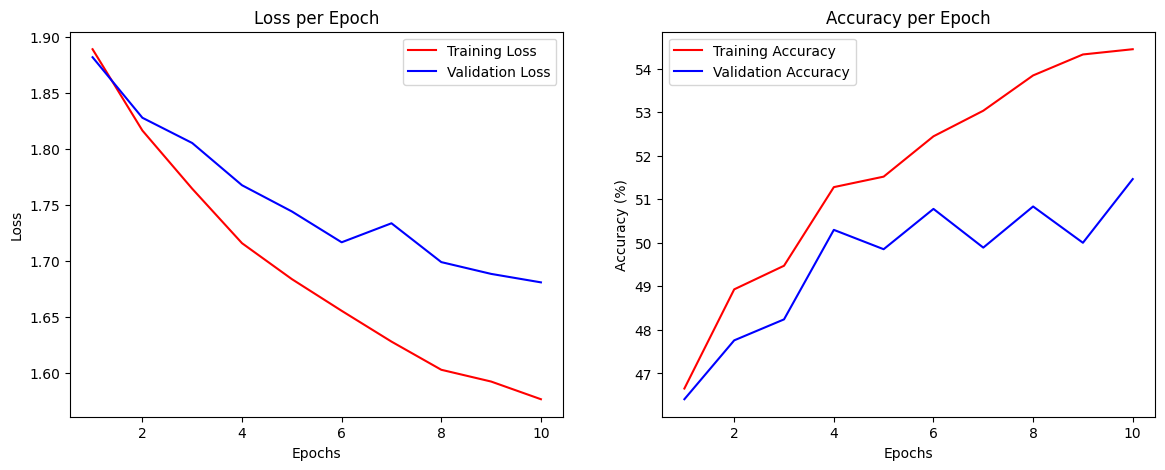

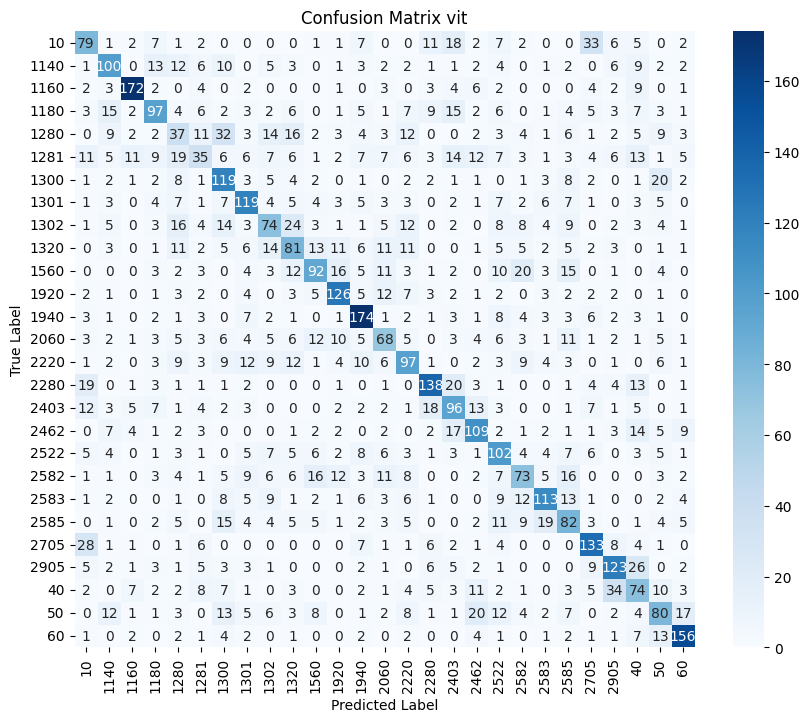

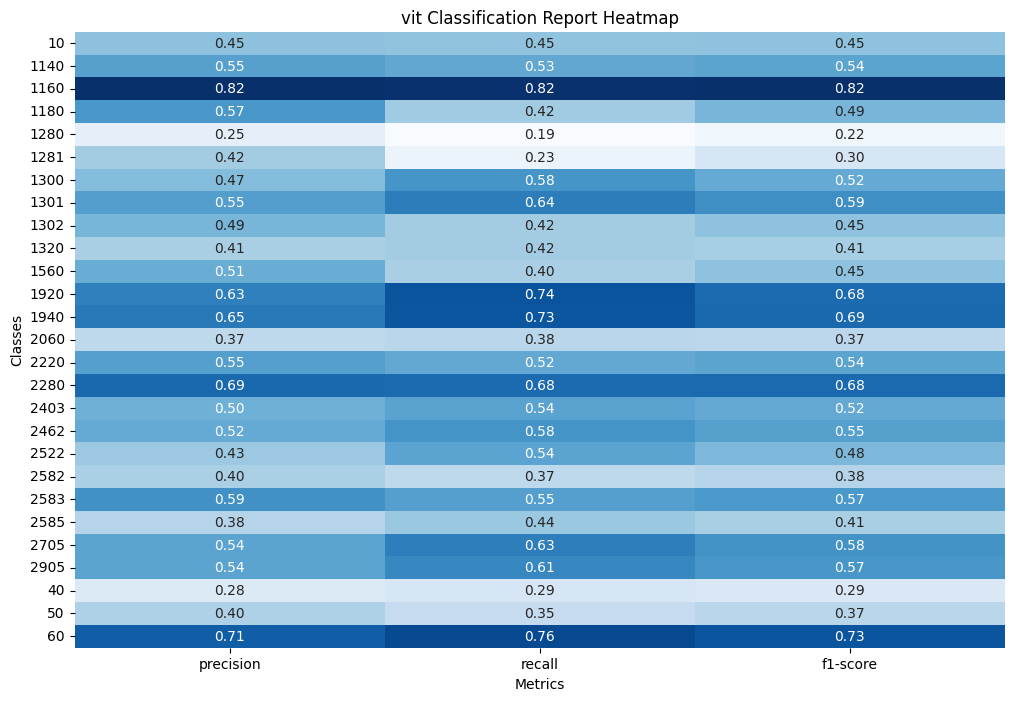

In [15]:
# Nombre de classes
num_classes = 27
print("Nombre de classes : ", num_classes)

# Nom des classes
class_names = val_loader.dataset.classes
print("Nom des classes :\n", class_names)

# Choix du modèle
model_name = 'vit'  # vgg, efficientnet, vit, resnet
print("Modèle : ", model_name)
model = get_model(model_name, num_classes)

# CPU or GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device : ", device)
model = model.to(device)

# path de sauvegarde checkpoint
path = 'save'
print("Path de sauvegarde : ", path)

# path de la dernière sauvegarde du modèle
checkpoint_path = os.path.join(path, f'{model_name}_2024-09-23_epoch3of30.pth')

# model, nouvelle epoch de départ et learning_rate de la dernière sauvegarde
model, start_epoch, learning_rate = load_model(checkpoint_path, model, device)

# Nombre d'epoch supplémentaires (pour la poursuite)
num_additional_epochs = 10

# training again
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model,
    model_name,
    device,
    path,
    train_loader,
    val_loader,
    learning_rate,
    num_additional_epochs
)

# Visualisation des métriques
plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
plot_confusion_matrix(model, model_name, val_loader, device, class_names)
plot_classification_report_heatmap(model, model_name, val_loader, device, class_names)